In [84]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

# Load dataset
df_1 = pd.read_csv(r"C:\Users\may\Desktop\dataset\CEAS_08.csv")
df_2 = pd.read_csv(r"C:\Users\may\Desktop\dataset\data.csv")
df_3 = pd.read_csv(r"C:\Users\may\Desktop\dataset\balanced.csv")

# Extract relevant features and target
df_1 = df_1[['sender', 'subject', 'body', 'label']]
df_2 = df_2.rename(columns={'Email Text': 'body', 'Email Type': 'label'})
df_3 = df_3.rename(columns={'class': 'label'})

# Convert Email Type to boolean
df_2['label'] = df_2['label'].map({'Safe Email': 0, 'Phishing Email': 1})

# Remove empty values
df_1 = df_1.dropna(subset=['body', 'subject', 'label'])
df_2 = df_2.dropna(subset=['body'])
df_3 = df_3.dropna(subset=['body', 'label'])

# Add missing columns
df_2['sender'] = ''
df_2['subject'] = ''
df_3['sender'] = ''
df_3['subject'] = ''

# Combine datasets
df = pd.concat([df_1, df_2, df_3], ignore_index=True)
df = df[df['label'].isin([0, 1])]

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
#nltk.download('wordnet')
#stemmer = PorterStemmer()
#lemmatizer = WordNetLemmatizer()

# Text Cleaning Function
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    #text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = ' '.join(word for word in text.split() if word not in stop_words)
    #text = ' '.join(lemmatizer.lemmatize(word, pos='v') for word in text.split())  # Apply Lemmatization
    #text = ' '.join(stemmer.stem(word) for word in text.split()) # Apply Porter Stemming
    return text

df['cleaned_sender'] = df['sender'].apply(clean_text)
df['cleaned_subject'] = df['subject'].apply(clean_text)
df['cleaned_body'] = df['body'].apply(clean_text)


[nltk_data] Downloading package stopwords to C:\Users\may/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


multinomial Naive Bayes

Accuracy: 0.9742475454691776
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      6046
           1       0.99      0.96      0.97      6380

    accuracy                           0.97     12426
   macro avg       0.97      0.97      0.97     12426
weighted avg       0.97      0.97      0.97     12426



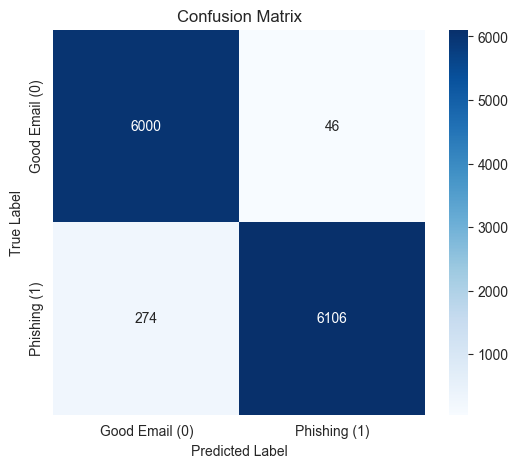

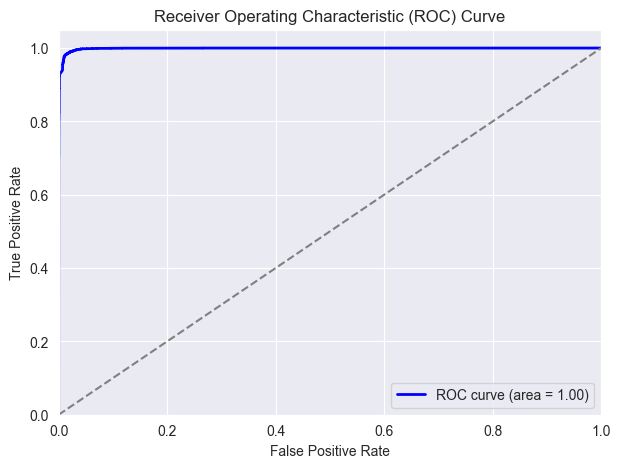

In [85]:
# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train Naive Bayes Model
nb_model = MultinomialNB(alpha=0.02)
nb_model.fit(X_train, y_train)

# Predictions
y_pred = nb_model.predict(X_test)
y_pred_proba = nb_model.predict_proba(X_test)[:, 1]

# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8571428571428571
              precision    recall  f1-score   support

           0       0.89      0.94      0.91        17
           1       0.67      0.50      0.57         4

    accuracy                           0.86        21
   macro avg       0.78      0.72      0.74        21
weighted avg       0.85      0.86      0.85        21



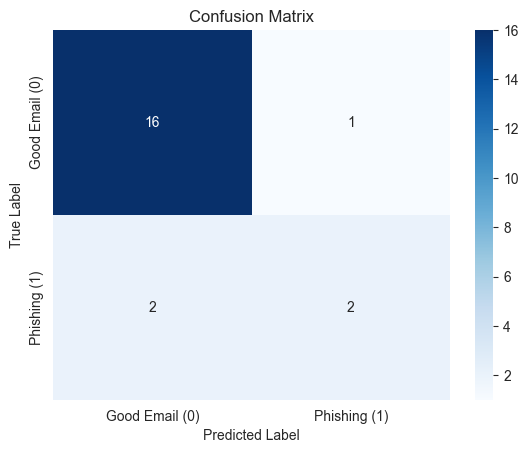

In [86]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
test_df['predicted_label'] = nb_model.predict(X_test_combined)
test_df['phishing_probability'] = nb_model.predict_proba(X_test_combined)[:, 1]


if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['predicted_label']))
    print(classification_report(test_df['label'], test_df['predicted_label']))

    # Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Show results
#print(test_df[['sender', 'subject', 'predicted_label', 'phishing_probability']].head())

# Save results with predictions
#test_df.to_excel(".xlsx", index=False)

Random Forest

Accuracy: 0.9761789795589892
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      6046
           1       0.99      0.97      0.98      6380

    accuracy                           0.98     12426
   macro avg       0.98      0.98      0.98     12426
weighted avg       0.98      0.98      0.98     12426



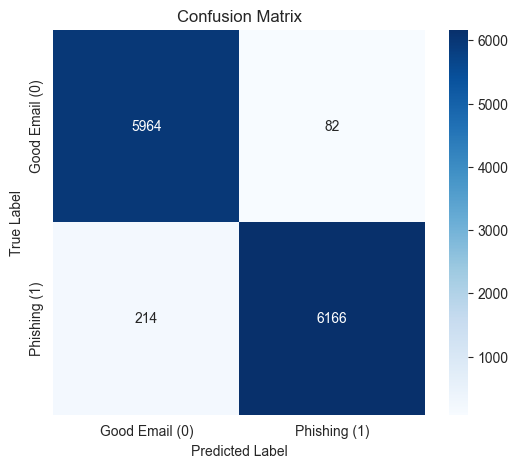

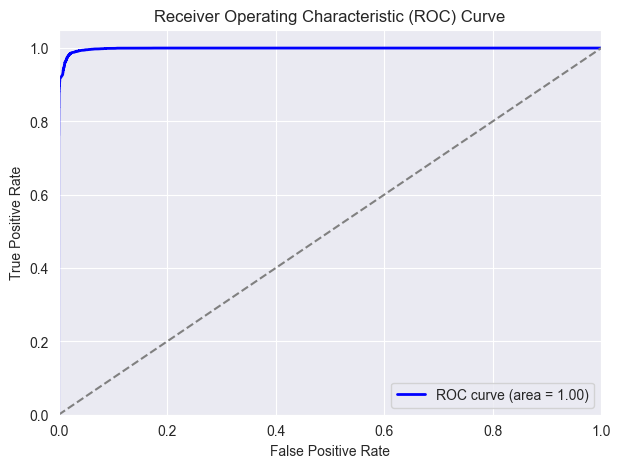

In [87]:
from sklearn.ensemble import RandomForestClassifier
# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train Random Forest Model, trees=50
rf_model = RandomForestClassifier(n_estimators=670, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8095238095238095
              precision    recall  f1-score   support

           0       0.93      0.82      0.88        17
           1       0.50      0.75      0.60         4

    accuracy                           0.81        21
   macro avg       0.72      0.79      0.74        21
weighted avg       0.85      0.81      0.82        21



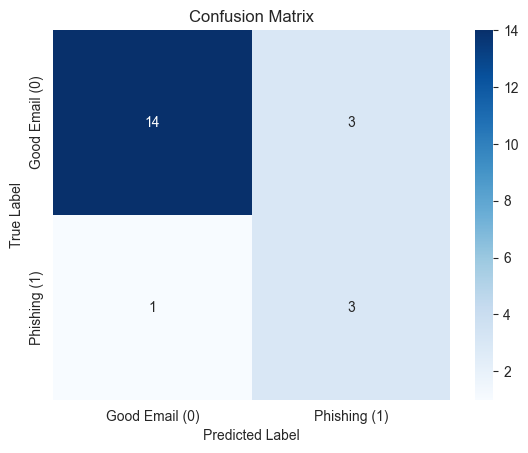

In [88]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
test_df['predicted_label'] = rf_model.predict(X_test_combined)
test_df['phishing_probability'] = rf_model.predict_proba(X_test_combined)[:, 1]


if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['predicted_label']))
    print(classification_report(test_df['label'], test_df['predicted_label']))

    # Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


xgboost

C:\Users\may\PycharmProjects\ML\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:51:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9875261548366329
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      6046
           1       0.98      0.99      0.99      6380

    accuracy                           0.99     12426
   macro avg       0.99      0.99      0.99     12426
weighted avg       0.99      0.99      0.99     12426



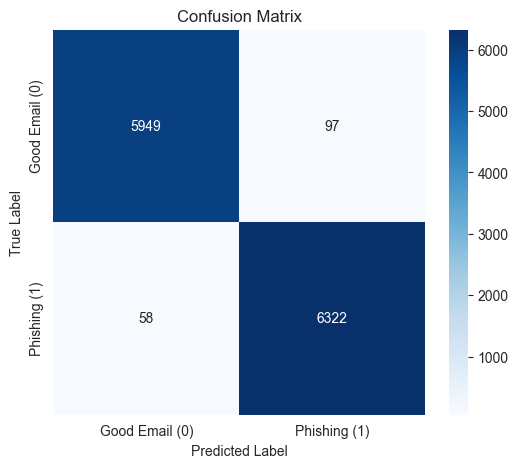

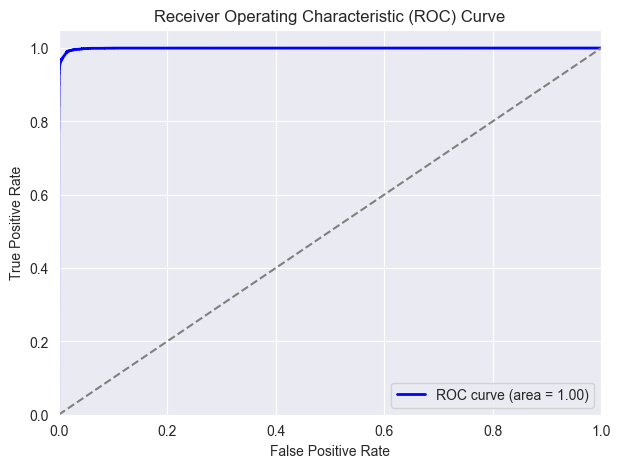

In [89]:
from xgboost import XGBClassifier
# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train XGBoost Model, disable the internal label encoder and avoid any related warnings or errors, logarithmic loss for classification problems
xgb_model = XGBClassifier(n_estimators=980, random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8095238095238095
              precision    recall  f1-score   support

           0       1.00      0.76      0.87        17
           1       0.50      1.00      0.67         4

    accuracy                           0.81        21
   macro avg       0.75      0.88      0.77        21
weighted avg       0.90      0.81      0.83        21



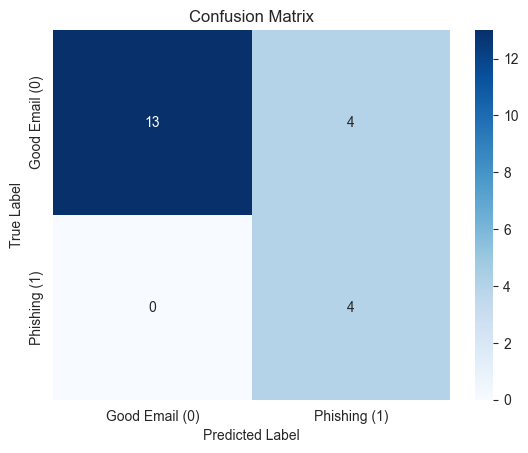

In [90]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
test_df['predicted_label'] = xgb_model.predict(X_test_combined)
test_df['phishing_probability'] = xgb_model.predict_proba(X_test_combined)[:, 1]


if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['predicted_label']))
    print(classification_report(test_df['label'], test_df['predicted_label']))

    # Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Show results
#print(test_df[['sender', 'subject', 'predicted_label', 'phishing_probability']].head())

# Save results with predictions
#test_df.to_excel(".xlsx", index=False)

Logistic Regression

Accuracy: 0.9911475937550298
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      6046
           1       0.99      0.99      0.99      6380

    accuracy                           0.99     12426
   macro avg       0.99      0.99      0.99     12426
weighted avg       0.99      0.99      0.99     12426



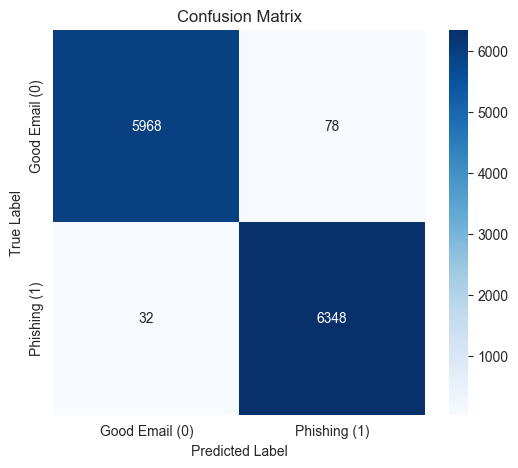

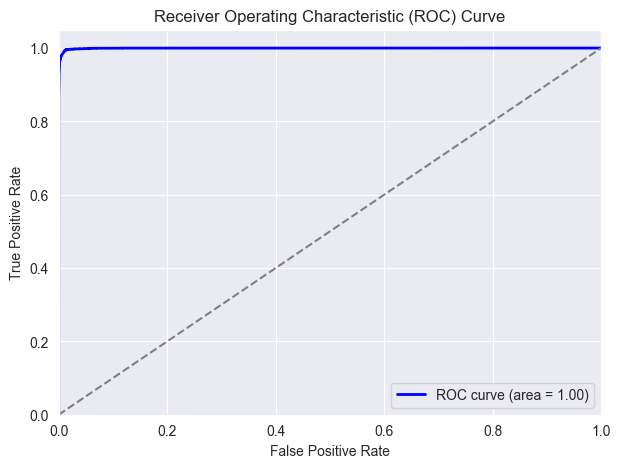

In [91]:
from sklearn.linear_model import LogisticRegression
# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

logreg_model = LogisticRegression(C=9, random_state=42, n_jobs=-1)
logreg_model.fit(X_train, y_train)

# Predictions
y_pred = logreg_model.predict(X_test)
y_pred_proba = logreg_model.predict_proba(X_test)[:, 1]

# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.6190476190476191
              precision    recall  f1-score   support

           0       0.85      0.65      0.73        17
           1       0.25      0.50      0.33         4

    accuracy                           0.62        21
   macro avg       0.55      0.57      0.53        21
weighted avg       0.73      0.62      0.66        21



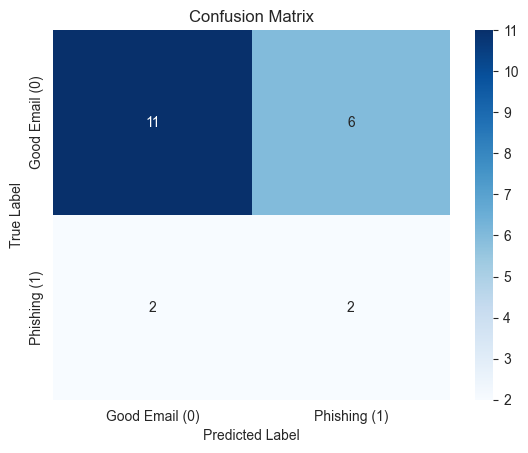

In [92]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
test_df['predicted_label'] = logreg_model.predict(X_test_combined)
test_df['phishing_probability'] = logreg_model.predict_proba(X_test_combined)[:, 1]

if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['predicted_label']))
    print(classification_report(test_df['label'], test_df['predicted_label']))

    # Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Show results
#print(test_df[['sender', 'subject', 'predicted_label', 'phishing_probability']].head())

# Save results with predictions
#test_df.to_excel(".xlsx", index=False)

K-Nearest Neighbors

Accuracy: 0.9426203122485112
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      6046
           1       0.95      0.94      0.94      6380

    accuracy                           0.94     12426
   macro avg       0.94      0.94      0.94     12426
weighted avg       0.94      0.94      0.94     12426



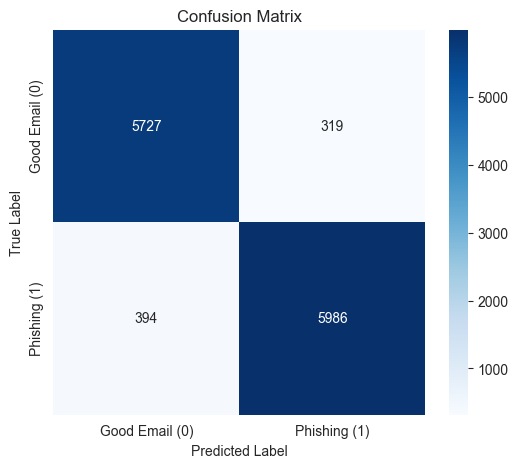

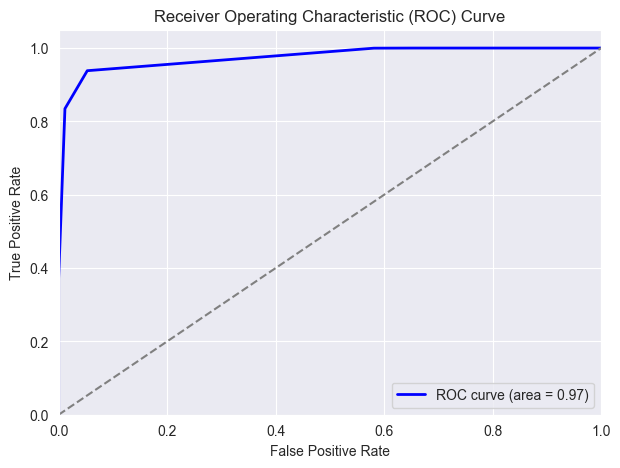

In [93]:
from sklearn.neighbors import KNeighborsClassifier
# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

#  consider the 5 nearest neighbors when determining the class of a new data point
knn_model = KNeighborsClassifier(n_neighbors=6, n_jobs= -1)
knn_model.fit(X_train, y_train)

# Predictions
y_pred = knn_model.predict(X_test)
y_pred_proba = knn_model.predict_proba(X_test)[:, 1]

# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.47619047619047616
              precision    recall  f1-score   support

           0       1.00      0.35      0.52        17
           1       0.27      1.00      0.42         4

    accuracy                           0.48        21
   macro avg       0.63      0.68      0.47        21
weighted avg       0.86      0.48      0.50        21



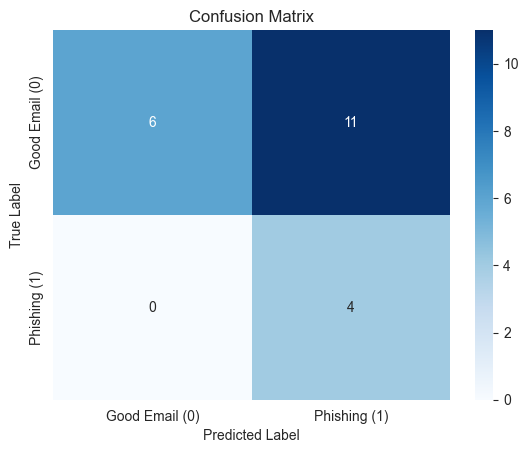

In [94]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
test_df['predicted_label'] = knn_model.predict(X_test_combined)
test_df['phishing_probability'] = knn_model.predict_proba(X_test_combined)[:, 1]


if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['predicted_label']))
    print(classification_report(test_df['label'], test_df['predicted_label']))

    # Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Show results
#print(test_df[['sender', 'subject', 'predicted_label', 'phishing_probability']].head())

# Save results with predictions
#test_df.to_excel(".xlsx", index=False)

AdaBoost

In [95]:
"""""""""""
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# DecisionTreeClassifier with max_depth=1 (weak learner), tree size =50
ada_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),n_estimators=50, random_state=42)
ada_model.fit(X_train, y_train)

# Predictions
y_pred = ada_model.predict(X_test)
y_pred_proba = ada_model.predict_proba(X_test)[:, 1]

# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

SyntaxError: incomplete input (3718320426.py, line 1)

In [ ]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
test_df['predicted_label'] = ada_model.predict(X_test_combined)
test_df['phishing_probability'] = ada_model.predict_proba(X_test_combined)[:, 1]


if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['predicted_label']))
    print(classification_report(test_df['label'], test_df['predicted_label']))

    # Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Show results
#print(test_df[['sender', 'subject', 'predicted_label', 'phishing_probability']].head())

# Save results with predictions
#test_df.to_excel(".xlsx", index=False)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base models
base_models = [
    ('nb', MultinomialNB()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]

# Define meta-model
meta_model = LogisticRegression()

# Create Stacking Classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Train Stacking model
stacking_model.fit(X_train, y_train)

# Predictions
y_pred_stack = stacking_model.predict(X_test)

# Evaluate Performance
print("Stacking Model Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Stacking Model Classification Report:\n", classification_report(y_test, y_pred_stack))

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Phishing', 'Phishing'], yticklabels=['Non-Phishing', 'Phishing'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Voting Classifier')
plt.show() """

Stacking Classifier

voting

C:\Users\may\PycharmProjects\ML\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:28:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ensemble Accuracy: 0.9927571221632062
Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      6046
           1       0.99      0.99      0.99      6380

    accuracy                           0.99     12426
   macro avg       0.99      0.99      0.99     12426
weighted avg       0.99      0.99      0.99     12426



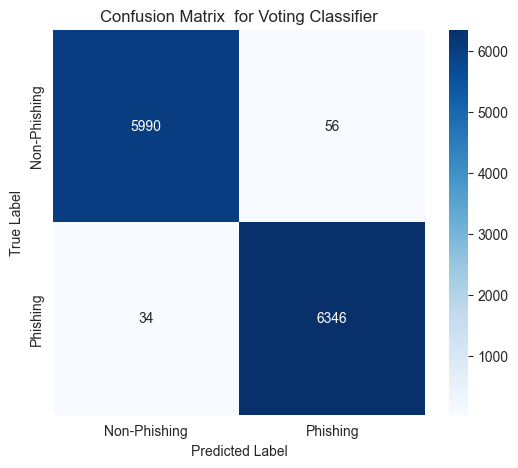

In [105]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier

# Define base models
nb_model = MultinomialNB(alpha=0.02)
rf_model = RandomForestClassifier(n_estimators=670, random_state=42, n_jobs=-1)
xgb_model = XGBClassifier(n_estimators=980, random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
logreg_model = LogisticRegression(C=9, random_state=42, n_jobs=-1)
knn_model = KNeighborsClassifier(n_neighbors=6, n_jobs= -1)

# Create Voting Classifier with all models
ensemble_model = VotingClassifier(
    estimators=[('nb', nb_model), ('rf', rf_model), ('xgb', xgb_model), ('knn', knn_model), ('logreg', logreg_model)],
    voting='soft'  # 'soft' voting uses probabilities, 'hard' voting uses majority class
)

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Predictions
y_pred = ensemble_model.predict(X_test)
y_pred_proba_ensemble = ensemble_model.predict_proba(X_test)  # Define probabilities

# Evaluate Performance
print("Ensemble Accuracy:", accuracy_score(y_test, y_pred))
print("Ensemble Classification Report:\n", classification_report(y_test, y_pred))

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Phishing', 'Phishing'], yticklabels=['Non-Phishing', 'Phishing'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix  for Voting Classifier')
plt.show()

In [106]:
# Analyze individual model predictions and probabilities
models = {'nb': nb_model, 'rf': rf_model, 'xgb': xgb_model, 'knn': knn_model, 'logreg': logreg_model}
individual_preds = {}
individual_probas = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Train individually
    individual_preds[name] = model.predict(X_test)
    individual_probas[name] = model.predict_proba(X_test)

# Determine "winner" for each test instance
winners = []
ensemble_proba_1 = y_pred_proba_ensemble[:, 1]  # Ensemble prob for class 1
n_samples = len(y_test)

for i in range(n_samples):
    ensemble_pred = y_pred[i]
    ensemble_prob = ensemble_proba_1[i]

    # Store each model's prediction and probability for this instance
    model_scores = {}
    for name in models:
        pred = individual_preds[name][i]
        prob = individual_probas[name][i, 1] if pred == 1 else individual_probas[name][i, 0]
        model_scores[name] = (pred, prob)

    # Winner: Model whose predicted class matches ensemble and has highest confidence
    winner = max(model_scores, key=lambda k: model_scores[k][1] if model_scores[k][0] == ensemble_pred else -1)
    winners.append(winner)

C:\Users\may\PycharmProjects\ML\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:41:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [107]:
# Count how often each model "wins"
winner_counts = {name: winners.count(name) for name in models}
print("\nWinner counts across all test instances:")
for name, count in winner_counts.items():
    print(f"{name}: {count} times ({count/n_samples*100:.2f}%)")

# Average probabilities for class 1 to see overall influence
print("\nAverage probabilities for class 1:")
for name in models:
    avg_prob = np.mean(individual_probas[name][:, 1])
    print(f"{name}: {avg_prob:.4f}")
print(f"Ensemble: {np.mean(ensemble_proba_1):.4f}")


Winner counts across all test instances:
nb: 6603 times (53.14%)
rf: 1014 times (8.16%)
xgb: 3143 times (25.29%)
knn: 1582 times (12.73%)
logreg: 84 times (0.68%)

Average probabilities for class 1:
nb: 0.4878
rf: 0.5122
xgb: 0.5130
knn: 0.6026
logreg: 0.5127
Ensemble: 0.5256


Test Accuracy: 0.8095238095238095
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        17
           1       0.50      0.50      0.50         4

    accuracy                           0.81        21
   macro avg       0.69      0.69      0.69        21
weighted avg       0.81      0.81      0.81        21



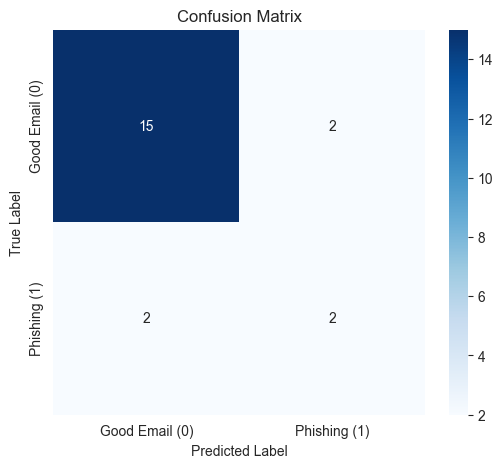

C:\Users\may\PycharmProjects\ML\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:12:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Results saved to C:\Users\may\Desktop\test_predictions_with_analysis.xlsx


In [109]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
y_pred = ensemble_model.predict(X_test_combined)
y_pred_proba_ensemble = ensemble_model.predict_proba(X_test_combined)

# Store predictions in the dataframe
test_df['ensemble_predicted_label'] = y_pred
test_df['ensemble_prob_class0'] = y_pred_proba_ensemble[:, 0]
test_df['ensemble_prob_class1'] = y_pred_proba_ensemble[:, 1]

# Evaluate Performance
if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['ensemble_predicted_label']))
    print(classification_report(test_df['label'], test_df['ensemble_predicted_label']))

    # Compute and Plot Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['ensemble_predicted_label'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Good Email (0)', 'Phishing (1)'],
                yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Analyze individual model predictions and probabilities on new test set
models = {'nb': nb_model, 'rf': rf_model, 'xgb': xgb_model, 'knn': knn_model, 'logreg': logreg_model}
individual_preds = {}
individual_probas = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Train on original training data
    individual_preds[name] = model.predict(X_test_combined)
    individual_probas[name] = model.predict_proba(X_test_combined)

# Add individual model predictions and probabilities to test_df, and determine winner
n_samples = len(test_df)
winners = []

for i in range(n_samples):
    ensemble_pred = test_df['ensemble_predicted_label'].iloc[i]  # Fixed: Use defined column
    ensemble_prob = test_df['ensemble_prob_class1'].iloc[i]      # Fixed: Use defined column

    # Store each model's prediction and probability
    model_scores = {}
    for name in models:
        pred = individual_preds[name][i]
        prob = individual_probas[name][i, 1] if pred == 1 else individual_probas[name][i, 0]
        model_scores[name] = (pred, prob)
        # Add to test_df
        test_df.loc[i, f'{name}_pred'] = pred
        test_df.loc[i, f'{name}_prob_class0'] = individual_probas[name][i, 0]
        test_df.loc[i, f'{name}_prob_class1'] = individual_probas[name][i, 1]

    # Winner: Model whose predicted class matches ensemble and has highest confidence
    winner = max(model_scores, key=lambda k: model_scores[k][1] if model_scores[k][0] == ensemble_pred else -1)
    winners.append(winner)
    test_df.loc[i, 'winner_model'] = winner

# Output the enriched test_df to Excel
output_file = r"C:\Users\may\Desktop\test_predictions_with_analysis.xlsx"
test_df.to_excel(output_file, index=False)

print(f"Results saved to {output_file}")